In [1]:
# from cntools.datasets import Dataset
from general import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
import networkx as nx
from scipy import ndimage as ndi
from matplotlib.lines import Line2D
import sys
sys.path.insert(0, '..')
plt.rcParams["font.family"] = 'Arial'

In [2]:
# HLT

ds = pickle.load(open('../data/HLT/HLT_ds.pkl', 'rb'))
n_cns = 11
exps = ['LN', 'tonsil9338', 'tonsil8953', 'spleen']
cn_ids = [i for i in range(n_cns)]
all_cn_ids = [i for i in range(n_cns)]
ref = {'LN': 'Lymph node', 'tonsil': 'Tonsil', 'spleen': 'Spleen', 'tonsil9338': 'Tonsil 1', 'tonsil8953': 'Tonsil 2'}

# Uncomment one of these results on HLT

# cns = cns_remap(pickle.load(open('../cn/HLT/CC/cns_n_cns=11_m=20_naive.pkl', 'rb')), [6, 1, 3, 2, 9, 5, 0, 8, 4, 10, 7])
# palt = {i:j for i,j in enumerate([(sns.color_palette('bright',10)+[(0, 0, 0)])[i] for i in [6, 1, 3, 2, 9, 5, 0, 8, 4, 10, 7]])}
# ind = ['cnGr: Granulocyte enriched', 'cnBT: B & T cell enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnVT: Blood vessel & T cell enriched', 'cnEp: Epithelial cell enriched', 'cnDZ: Dark zone', 'cnLZ: Light zone']
# cns_not_dilate = [0, 2, 3, 4, 5, 6, 7, 8]

# cns = cns_remap(pickle.load(open('../cn/HLT/CF-IDF/cns_n_cns=11_eps=23_r=0.8_naive.pkl', 'rb')), [2, 9, 10, 3, 8, 4, 5, 0, 7, 6, 1])
# palt = {i:j for i,j in enumerate([(sns.color_palette('bright',10)+[(0, 0, 0)])[i] for i in [2, 9, 10, 3, 8, 4, 5, 0, 7, 6, 1]])}
# ind = ['cnGr: Granulocyte enriched', 'cnGrMph: Granulocyte & macrophage enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnPl: Plasma cell enriched', 'cnEp: Epithelial cell enriched', 'cnLZDZ: Light & dark zone', 'cnMphNK: Macrophage & NK cell enriched']
# cns_not_dilate = [0, 1, 2, 3, 4, 5, 6, 8, 10]

cns = cns_remap(pickle.load(open('../cn/HLT/CNE/cns_n_cns=11_perp=15_lam=0.25_naive.pkl', 'rb')), [1, 6, 2, 8, 9, 4, 7, 5, 3, 10, 0])
palt = {i:j for i,j in enumerate([(sns.color_palette('bright',10)+[(0, 0, 0)])[i] for i in [1, 6, 2, 8, 9, 4, 7, 5, 3, 10, 0]])}
ind = ['cnGr: Granulocyte enriched', 'cnBT: B & T cell enriched', 'cnMph: Macrophage enriched', 'cnT: T cell enriched', 'cnV: Blood vessel', 'cnB: B cell enriched', 'cnTsp: Tetraspanin positive cell enriched', 'cnPl: Plasma cell enriched', 'cnEp: Epithelial cell enriched', 'cnDZ: Dark zone', 'cnLZ: Light zone']
cns_not_dilate = [0, 2, 3, 4, 5, 6, 8]

In [ ]:
c = []
for sample in ds.data:
    for image in ds.data[sample]:
        c_tmp = pd.DataFrame(ds.data[sample][image].locs, columns={'X', 'Y'})
        c_tmp['Exp'] = image
        c_tmp['NEIGH_newGC'] = cns[sample][image]
        c.append(c_tmp)
c = pd.concat(c).reset_index(drop=True)

In [ ]:
'''
this code converts the cell CN assignments into an image,
then uses scipy label function to identify instances, which are connected components of each CN 
'''

imgs = {}
lab_imgs = {}
for exp in exps:
    exp_cells = c.loc[c['Exp']==exp]

    downsamp = 50
    x = (exp_cells['X']/downsamp).astype(int)
    y = (exp_cells['Y']/downsamp).astype(int)
    y = max(y)-y
    xdim = 1+max(x)
    ydim = 1+max(y)
    imgs[exp] = {}
    lab_imgs[exp] = {}

    for cn in cn_ids:
        
        cnx = x[exp_cells['NEIGH_newGC']==cn]
        cny = y[exp_cells['NEIGH_newGC']==cn]
        img = np.zeros((ydim,xdim),dtype = int)
        np.add.at(img, (cny, cnx),1)
        imgs[exp][cn]=img

        if cn in cns_not_dilate:
            thresh = 0
            dilate = False
        else:
            thresh = 0
            dilate = True

        if dilate:
            dil = ndi.binary_dilation(img>thresh)
        else:
            dil = img>thresh
        lab_img, _ = ndi.label(dil)
        sizes = np.zeros((1+np.max(lab_img)))
        np.add.at(sizes,lab_img.flatten(),1)
        lab_img[np.isin(lab_img,np.arange(len(sizes))[sizes<20])] = 0   
        lab_imgs[exp][cn]=lab_img

In [ ]:
'''
this code builds a graph for each tissue, vertices correspond to instances of a CN and edges correspond to adjacency
'''
gs = {}
for exp in exps:
    g = nx.Graph()
    for i,cn1 in enumerate(cn_ids):
        for j,cn2 in enumerate(cn_ids):
            if i<=j:
                continue
            lab1 = lab_imgs[exp][cn1]
            lab2 = lab_imgs[exp][cn2]
            intrx = np.zeros((np.max(lab1)+1, np.max(lab2)+1))
            np.add.at(intrx, (lab1.flatten(),lab2.flatten()),1)
            intrx[0,:] = -1
            intrx[:,0] = -1
            indexes = np.where(intrx>0)
            for e0,e1 in zip(*indexes):
                g.add_edge((exp,cn1,e0),(exp,cn2,e1))
    gs[exp] = g.copy()    

In [ ]:
'''
this code takes a motif and finds all the extensions, keeping track of which instances can be extended
the input info it needs includes graphs and dicts that it updates
g: tissue graph
tc: motif
tc_to_c : dict motifs -> instances
L_graph : graph of motif extensions
L_to_c : dict edges of L_graph -> instances of source of edge that extend 
tc_to_e : dict motifs -> experiments they're found it

a motif (typically referred to as tc in the code) is stored as a tuple (A,B,C) where:
A is a sorted tuple of sorted pairs of CNs representing the adjacencies in the motif
B is a sorted tuple of CNs representing the CNs in the motif
C is a sorted tuple of sorted pairs of CN representing the 'NOT' adjacencies
'''

def extend_motif(g,tc,tc_to_c, L_to_c, L_graph,tc_to_e):
    ty_edges, ty_nodes = tc
    samp = tc_to_c[tc]
    if len(samp) >5000:
        samp = list(samp)
        idd = np.arange(len(samp))
        np.random.shuffle(idd)
        samp = [samp[i] for i in idd[:5000]]
        
    for tm in samp:
        for tm_node in tm:
            for e0,e1 in g.edges(tm_node):
                e = e0
                if e ==tm_node:
                    e = e1
                exp, new_ty, new_inst = e
                
                new_edge = tuple(sorted([e0[1],e1[1]]))
                if  new_edge in ty_edges:
                    continue
                
                ty_node_set = set(ty_nodes)
                
                if new_ty in ty_node_set:
                    kv = {i:j for i,j in zip(ty_nodes,tm)}
                    if kv[new_ty]!=e:
                        continue
    
                ty_node_set.add(new_ty)
                new_ty_nodes = tuple(sorted(ty_node_set))
                idx = {tt:nod for tt,nod in zip(ty_nodes,tm)}
                idx[new_ty] = e
                new_tm = tuple([idx[j] for j in new_ty_nodes])
                
                ty_edge_set = set(ty_edges)
                ty_edge_set.add(new_edge)
                
                new_ty_edges = tuple(sorted(ty_edge_set))
                
                new_tc = (new_ty_edges,new_ty_nodes)
                tc_to_c.setdefault(new_tc,set()).add(new_tm)
                
                L_to_c.setdefault((tc,new_tc), set()).add(tm)
                tc_to_e.setdefault(new_tc,set()).add(tm[0][0])
                L_graph.add_edge(tc,new_tc)

In [ ]:
'''
this function takes a graph and uses extend motifs above to find all the motifs, their instances, 
as well as which motifs extend
'''
def build_motifs(g):
    tc_to_c = {}
    tc_to_e = {}

    for e0,e1 in g.edges():
        exp0,cn0,i0 = e0
        exp1,cn1,i1 = e1
        tc = ((tuple(sorted([cn0,cn1])),), tuple(sorted([cn0,cn1])))
        tm = tuple(sorted([e0,e1], key = lambda x: x[1]))
        tc_to_c.setdefault(tc, set()).add(tm)
        tc_to_e.setdefault(tc, set()).add(exp0)

    #take conserved motifs built from chains and adding
    L_to_c = {}
    L_graph = nx.DiGraph()
    for tc in tc_to_c:
        L_graph.add_node(tc)

    #expand them with add node motif    
    for i in range(11):
        leaves = [t for t in L_graph.nodes() if L_graph.out_degree(t)==0 and (len(t[1])<=4)]
        print(i,'---')
        print(len(leaves))
        for tc in leaves:
            extend_motif(g,tc,tc_to_c, L_to_c, L_graph,tc_to_e)
    return tc_to_c,L_to_c, L_graph

In [ ]:
tc_to_cs = {}
L_to_cs = {}
L_graphs = {}
for exp in exps:
    tc_to_cs[exp],L_to_cs[exp],L_graphs[exp] = build_motifs(gs[exp])

In [ ]:
'''
this makes one dict merging the instances of each CN across the two tonsils
'''
tc_to_cs['tonsil']={}
L_to_cs['tonsil'] = {}

for k in set(tc_to_cs['tonsil8953'].keys()).union(set(tc_to_cs['tonsil9338'].keys())):
    tc_to_cs['tonsil'][k] = tc_to_cs['tonsil8953'].setdefault(k,set()).union(tc_to_cs['tonsil9338'].setdefault(k,set()))
for k in set(L_to_cs['tonsil8953'].keys()).union(set(L_to_cs['tonsil9338'].keys())):
    L_to_cs['tonsil'][k] = L_to_cs['tonsil8953'].setdefault(k,set()).union(L_to_cs['tonsil9338'].setdefault(k,set()))

L_graphs['tonsil'] = nx.DiGraph() 
for e0,e1 in set(L_graphs['tonsil9338'].edges).union(set(L_graphs['tonsil8953'].edges)):
    L_graphs['tonsil'].add_edge(e0,e1)

In [ ]:
def pb_inst(c1,c2,inst_set):
    instmap = {cn:i for i,cn in enumerate(c2[1])}
    return set([tuple([inst2[instmap[cn]] for cn in c1[1]]) for inst2 in inst_set])  

In [ ]:
'''
this is the code that builds the graph of minimal implications 
''' 

def added_piece(e0,e1):
    if len(e1)==3:
        l = set(list(e1[2])).intersection(set(list(e1[1])))
        if len(l)==2:
            ad = 'not=_'+str(e1[2])
        if len(l)==1:
            ad = str(list(l)[0]) + '_not_' + str(e1[2])
    if len(e1)==2:
        new_edge = list(set(list(e1[0]))- set(list(e0[0])))[0]
        if len(e1[1])==len(e0[1]):
            ad = '='+str(new_edge)
        else:
            new_node = list(set(list(e1[1]))-set(list(e0[1])))[0]
            ad_point = list(set(list(new_edge))-set([new_node]))[0]
            ad = str(ad_point)+'_'+str(new_edge)
    return ad

hom_graphs = {}
pruned_graphs = {}
mod_graphs = {}
added_pieces = {}
for exp in ['LN','tonsil9338','tonsil8953','tonsil','spleen']:
    L_graph = L_graphs[exp].copy()
    tc_to_c = tc_to_cs[exp].copy()
    L_to_c = L_to_cs[exp].copy()

    for node in [a for a in L_graph.nodes() if len(a[1])==2]:
        for i,x in enumerate(node[1]):
            tc_to_c[(tuple(),(x,))] = set()
            L_to_c[((tuple(),(x,)),node)] = set()

    for node in [a for a in L_graph.nodes() if len(a[1])==2]:
        for i,x in enumerate(node[1]):
            L_graph.add_edge((tuple(),(x,)),node)
            for ch in tc_to_c[node]:
                tc_to_c.setdefault((tuple(),(x,)), set()).add(ch[i])
                L_to_c.setdefault(((tuple(),(x,)),node), set()).add(ch[i])

    #this bit adds the 'nots' for all possible cn additions (although only for individual nodes)
    for e0 in list(L_graph.nodes()):
        if len(e0[0])>0:
            continue
        for n in e0[1]:
            for cn in all_cn_ids:
                if cn==n:
                    continue
                if ((),(cn,)) not in tc_to_c:
                    continue
                
                added_comp = tuple(sorted([n,cn]))
                comp = (e0[0], e0[1], added_comp)
                L_graph.add_edge(e0,comp)
                new_ty = (tuple(sorted(set([added_comp] + list(e0[0])))), tuple(sorted(set([cn] + list(e0[1])))))
                if (e0,new_ty) in L_to_c:
                    tc_to_c[comp] = tc_to_c[e0] - L_to_c[e0,new_ty]
                    L_to_c[e0,comp] = tc_to_c[e0] - L_to_c[e0,new_ty]
                else:
                    tc_to_c[comp] = tc_to_c[e0]
                    L_to_c[e0,comp] = tc_to_c[e0]

    #this bit adds the 'nots' for only those additions at each step for which there are actual lifts
    for e0,e1 in list(L_graph.edges()):
        if len(e0[0])<1:
            continue
        added_edge = list(set(list(e1[0])) - set(list(e0[0])))[0]
        comp = (e0[0], e0[1], added_edge)
        L_graph.add_edge(e0,comp)
        tc_to_c[comp] = tc_to_c[e0]-L_to_c[e0,e1]
        L_to_c[e0,comp] = tc_to_c[e0]-L_to_c[e0,e1]
    
    mod_graphs[exp] = L_graph.copy()
    
    # pruned graph is the graph of all assembly rules
    pruned_graph = nx.DiGraph()
    thresh = .7
    for e in L_graph.edges():
        if len(tc_to_c[e[0]])<5:
            continue
            
        if len(e[1])==3:
            k2_0 = tuple(sorted(set(list(e[0][0])).union(set([e[1][2]]))))
            k2_1 = tuple(sorted(set(list(e[0][1])).union(set(list(e[1][2])))))
            k2 = (k2_0, k2_1)
            if len(tc_to_c.setdefault(k2, set())) >5:
                continue
        if (len(L_to_c[e])/len(tc_to_c[e[0]]))>thresh:
            pruned_graph.add_edge(e[0],e[1])
    
    #this bit deletes edges which aren't transitive
    del_edges = set()
    thresh2 = .7
    for e0,e1 in pruned_graph.edges():
        for e00 in nx.ancestors(pruned_graph,e0):
            if len(pb_inst(e00,e1,tc_to_c[e1]))/len(tc_to_c[e00]) < thresh2:
                del_edges.add((e0,e1))
    
    for e0,e1 in del_edges:
        pruned_graph.remove_edge(e0,e1)
    
    # hom graph is the graph of basic rules
    hom_graph = nx.DiGraph()            
    thresh3 = 0.3
    for i in range(10):
        nodes = [n for n in pruned_graph.nodes() if ((len(n)==3) and len(n[0])==(i-1)) or ((len(n)==2) and len(n[0])==i)]
        for node in nodes:
            for _,e1 in pruned_graph.out_edges(node):
                add = True
                diff = added_piece(node,e1)
                for d in nx.ancestors(L_graph,node):
                    if d not in pruned_graph.nodes():
                        continue
                    for _,w in pruned_graph.out_edges(d):
                        if added_piece(d,w)==diff:
                            add = False
                if add:
                    hom_graph.add_edge(node,e1)
                    
    print(len(hom_graph.edges()))
    pruned_graphs[exp] = pruned_graph.copy()
    hom_graphs[exp] = hom_graph.copy()

    added_pieces[exp] = {}
    for e in hom_graphs[exp].edges():
        added_pieces[exp].setdefault(added_piece(*e),set()).add(e)

In [ ]:
'''
this just counts all the extensions and rules of each kind
'''
counts = {}
count_sets0 = {}
count_sets1 = {}
counts_all = {}
graphs = {}
for exp in exps:
    counts[exp] = {}
    count_sets0[exp] = {}
    count_sets1[exp] = {}
    counts_all[exp]= {}

    for e0, e1 in hom_graphs[exp].edges():
        if len(e1)==2:
            g0 = nx.Graph()
            for a in e0[1]:
                g0.add_node(a)
            for a0,a1 in e0[0]:
                g0.add_edge(a0,a1)
                
            g1 = nx.Graph()
            for a in e1[1]:
                g1.add_node(a)
            for a0,a1 in e1[0]:
                g1.add_edge(a0,a1)
                
            key = (tuple(sorted([g0.degree(n) for n in g0.nodes()])),tuple(sorted([g1.degree(n) for n in g1.nodes()])))
            graphs[key] = (g0,g1)
            counts[exp].setdefault(key,0)
            count_sets0[exp].setdefault(key,set()).add(e0)
            count_sets1[exp].setdefault(key,set()).add(e1)
            counts_all[exp].setdefault(key,set()).add((e0,e1))
            
            counts[exp][key]+=1

In [ ]:
rule_types = set(counts['tonsil8953'].keys()).union(set(counts['tonsil9338'].keys())).union(set(counts['LN'].keys())).union(set(counts['spleen'].keys()))
rule_types = sorted(rule_types,key = lambda x: (len(x[0]), x[0], len(x[1]),x[1]))

In [ ]:
for j,key in enumerate(rule_types):
    g0,g1 = graphs[key]
    pos = nx.drawing.nx_pydot.graphviz_layout(g1, prog='neato')
    for i,n in enumerate(g1.nodes()):
        col = sns.color_palette('tab10')[i]
   
    e0,e1 = list(set(g1.edges)-set(g0.edges))[0] 

In [ ]:
l = 0
for exp in exps:
    for _, key in enumerate(rule_types):
        l += 1

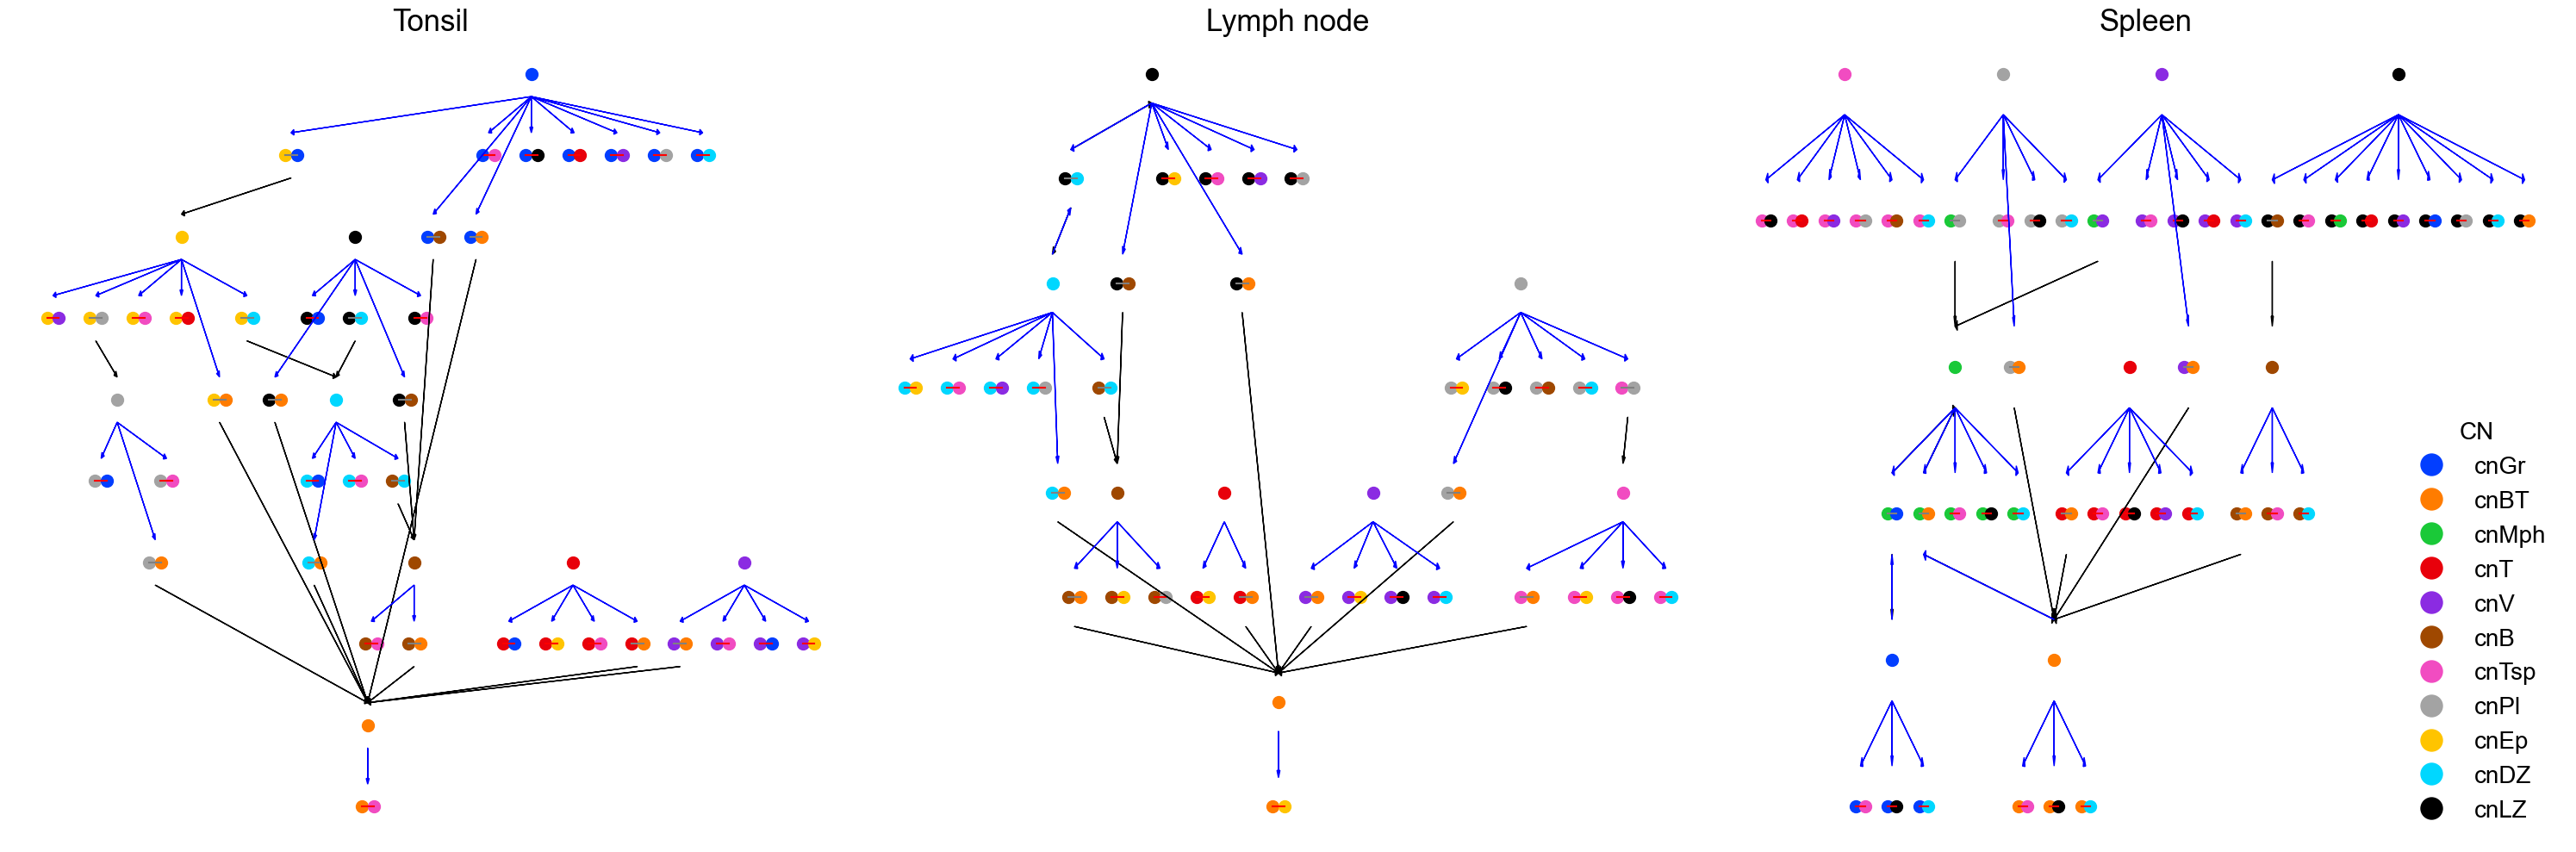

In [4]:
fig = plt.figure(figsize=(30,10))
i = 0

'''
this code plots the graphs as shown in the figure, adding the edges where a rule is not present
'''
for exp in ['tonsil','LN','spleen']:
    hom_graph = hom_graphs[exp]
    sub = nx.DiGraph()
    for e in hom_graph.edges():
        if (len(e[0][1])<=1):# or ((len(e[0][1])==3) and (len(e[1][1])==3)):
            sub.add_edge(e[0],e[1], col = 'blue')
            if len(e[1][1])==2:
                n = list(set(list(e[1][1])) - set(list(e[0][1])))[0]
                sub.add_edge(e[1],((),(n,)), col = 'black')

    draw = sub    

    draw2 = nx.DiGraph()
    nd = {e1:i for i,e1 in enumerate(draw.nodes())}
    ndinv = {i:e1 for i,e1 in enumerate(draw.nodes())}
    for n in draw.nodes():
        draw2.add_node(nd[n])
    for e in draw.edges():
        draw2.add_edge(nd[e[0]],nd[e[1]])
    pos = nx.drawing.nx_pydot.graphviz_layout(draw2, prog='dot')
    pos = {ndinv[k]:v for k,v in pos.items()}
    print(len(pos.keys()))
    print(len(draw2.nodes()))
    print(len(draw.nodes()))

    if exp in ['tonsil','LN','spleen']:
        fig.add_subplot(131 + i)
        i += 1
    
    pickle.dump(draw, open(f'../analysis_res/HLT/CNE/draw_{exp}.pkl', 'wb'))
    pickle.dump(pos, open(f'../analysis_res/HLT/CNE/pos_{exp}.pkl', 'wb'))
    # draw = pickle.load(open(f'../analysis_res/HLT/CNE/draw_{exp}.pkl', 'rb'))
    # pos = pickle.load(open(f'../analysis_res/HLT/CNE/pos_{exp}.pkl', 'rb'))

    for n in draw.nodes():
        col = 'black'
        if len(n[1])==1:
            if len(n)==2:
                h = plt.scatter(pos[n][0], pos[n][1], s = 100, c = [palt[n[1][0]]])
            if len(n)==3:
                h = plt.scatter(pos[n][0]-10, pos[n][1], s = 100, c = [palt[n[1][0]]])
                ne = list(set(list(n[2])) - set([n[1][0]]))[0]
                h = plt.scatter(pos[n][0]+10, pos[n][1], s = 100, c = [palt[ne]])
                plt.plot([pos[n][0]-10,pos[n][0]+10], [pos[n][1],pos[n][1]], color= 'red')
                
        if len(n[1])==2:
            h = plt.scatter(pos[n][0]-10, pos[n][1], s = 100, c = [palt[n[0][0][0]]])
            h = plt.scatter(pos[n][0]+10, pos[n][1], s = 100, c = [palt[n[0][0][1]]])
            plt.plot([pos[n][0]-10,pos[n][0]+10], [pos[n][1],pos[n][1]], color= 'grey')
    cols = nx.get_edge_attributes(draw, 'col')        
    for e0,e1 in draw.edges():
        weight = 0.4
        zorder = 5
        col = cols[e0,e1]
        if col =='black':
            zorder = 4
        x = pos[e0][0]
        dx = pos[e1][0]-x
        if pos[e1][1]<pos[e0][1]:
            y = pos[e0][1]-20
            dy = pos[e1][1]+20-y
        else:
            y = pos[e0][1]+20
            dy = pos[e1][1]-20-y

        plt.arrow(x,y,dx,dy,head_length=5, head_width=5,length_includes_head=True, color=col, zorder=zorder)
    plt.title(ref[exp], fontsize=25)
    plt.axis('off')

plt.tight_layout()

colors = sns.color_palette('bright', 10) + [(0, 0, 0)]
legend_1 = plt.legend(handles=[Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor=c, markersize=20) for c in (sns.color_palette('bright', 10) + [(0, 0, 0)])], labels=[i.split(':')[0] for i in ind], title='CN', loc='best', frameon=False, framealpha=1, edgecolor='k', fontsize=20) # loc=(-1.2, 0)
legend_1.get_title().set_fontsize('20')

plt.savefig(f'../analysis_res/HLT/CNE/assembly_rules.pdf', bbox_inches='tight')
plt.show()